For Task IV, you will use ParticleNet’s data for Quark/Gluon jet classification available here with its corresponding description.

● Choose 2 Graph-based architectures of your choice to classify jets as being quarks or gluons. Provide a description on what considerations you have taken to project this point-cloud dataset to a set of interconnected nodes and edges.

● Discuss the resulting performance of the 2 chosen architectures.

In [3]:
from tf_keras_model import get_particle_net_lite,get_particle_net
from tensorflow import keras
import logging
logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(levelname)s: %(message)s')
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Load the dataset
!wget https://zenodo.org/record/3164691/files/QG_jets.npz -P /content/data/ # used on colab
dataset = np.load('./data/QG_jets.npz',allow_pickle=True)

--2022-05-13 13:58:24--  https://zenodo.org/record/3164691/files/QG_jets.npz
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106689379 (102M) [application/octet-stream]
Saving to: ‘/content/data/QG_jets.npz’

QG_jets.npz         100%[===================>] 101.75M  21.9MB/s    in 5.3s    

2022-05-13 13:58:31 (19.1 MB/s) - ‘/content/data/QG_jets.npz’ saved [106689379/106689379]



In [5]:
# See what keys are present in the dataset
list(dataset.keys())

['X', 'y']

In [6]:
# Extract data as per keys
x = dataset['X']
y = dataset['y']

In [7]:
# Check the shape of the dataset
print(x.shape)
print(y.shape)

(100000, 139, 4)
(100000,)


As per the information of the dataset from [here](https://zenodo.org/record/3164691#.YigdGt9MHrB)

X: (100000,M,4), exactly 50k quark and 50k gluon jets, randomly sorted, where M is the max multiplicity of the jets in that file (other jets have been padded with zero-particles), and the features of each particle are its pt, rapidity, azimuthal angle, and pdgid.

y: (100000,), an array of labels for the jets where gluon is 0 and quark is 1.

In [8]:
# one hot encoding labels is needed else the following error 
# ValueError: Shapes (None, 1) and (None, 2) are incompatible
y = keras.utils.to_categorical(y)
print(y.shape)

(100000, 2)


I faced this error later during training and therefore one hot encoding is performed here.

From the paper on [Jet tagging via particle clouds](https://journals.aps.org/prd/pdf/10.1103/PhysRevD.101.056019)

The first EdgeConv block uses the spatial coordinates of the particles in the pseudorapidity-azimuth space to
compute the distances, while the subsequent blocks use the learned feature vectors as coordinates.

From the dataset we know that the features of each particle are its pt, rapidity, azimuthal angle, and pdgid


In [9]:
x, y = shuffle(x, y, random_state=0)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test , test_size=0.5, random_state=42)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_val.shape, y_val.shape)

(70000, 139, 4) (70000, 2)
(15000, 139, 4) (15000, 2)
(15000, 139, 4) (15000, 2)


Shapes of each input (`points`, `features`, `mask`)

Now we create masks for train, val and test

In [10]:
# mask
# find the maximum length vector in for each sample in 10000 samples with maximum number of non-zero values
mask_train = np.sum(x_train, axis=2) 
print(mask_train.shape)
print(mask_train[0])

# make the array binary
mask_train = np.array(mask_train !=0 , np.float32)
print(mask_train[0])

# reshape mask for a third axis
mask_train = mask_train.reshape(x_train.shape[0], x_train.shape[1], 1)
print(mask_train.shape)

(70000, 139)
[   29.20243269    27.50561143    30.26089051   220.41819997
    27.95042087    28.15969933   329.0687446     27.57628735
  -206.06003465   218.08468374    26.41602355    27.02195013
    31.79622486    26.59246689    26.88924931  -202.09822736
    26.71899363    31.23462352  -310.42681747    27.70451205
    30.7169403   -198.56554041  2233.77838649    36.42720615
    29.23621805  -187.38676832    33.46071738   268.17256202
    32.3521241  -2054.01856237   118.7019814     56.63953271
   151.53934524    57.07618763     0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.

In [11]:
# mask
# find the maximum length vector in for each sample in 10000 samples with maximum number of non-zero values
mask_val = np.sum(x_val, axis=2) 

# make the array binary
mask_val = np.array(mask_val !=0 , np.float32)

# reshape mask for a third axis
mask_val = mask_val.reshape(x_val.shape[0], x_val.shape[1], 1)
print(mask_val.shape)

(15000, 139, 1)


In [12]:
# mask
# find the maximum length vector in for each sample in 10000 samples with maximum number of non-zero values
mask_test = np.sum(x_test, axis=2) 

# make the array binary
mask_test = np.array(mask_test !=0 , np.float32)

# reshape mask for a third axis
mask_test = mask_val.reshape(x_test.shape[0], x_test.shape[1], 1)
print(mask_test.shape)

(15000, 139, 1)


We use the implementations from this [github repo](https://github.com/hqucms/ParticleNet) The input is formatted accordingly below for train, val and test

`points` contain rapidity, azimuthal angle used for computing the distance of KNN

`features`: the features of the particles. All the 4 features.

`mask` mask array taking a value of 0 for padded positions.

In [13]:
train_dataset = {
    'points': x_train[:,:,1:3],
    'features': x_train,
    'mask': mask_train
}

test_dataset = {
    'points': x_test[:,:,1:3],
    'features': x_test,
    'mask': mask_test
}

val_dataset = {
    'points': x_val[:,:,1:3],
    'features': x_val,
    'mask': mask_val
}

In [14]:
shapes = {
    'points': x_train[:,:,1:3].shape[1:],
    'features': x_train.shape[1:],
    'mask': mask_train.shape[1:]
}
shapes

{'features': (139, 4), 'mask': (139, 1), 'points': (139, 2)}

In [15]:
# particle net lite
num_classes = 2
model = get_particle_net_lite(num_classes, shapes)

In [35]:
# Training parameters
batch_size = 1024
epochs = 100

In [36]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 10:
        lr *= 0.1
    elif epoch > 20:
        lr *= 0.01
    logging.info('Learning rate: %f'%lr)
    return lr

In [37]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()

[2022-05-13 14:22:20,004] INFO: Learning rate: 0.001000


Model: "ParticleNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mask (InputLayer)              [(None, 139, 1)]     0           []                               
                                                                                                  
 tf.math.not_equal (TFOpLambda)  (None, 139, 1)      0           ['mask[0][0]']                   
                                                                                                  
 tf.cast (TFOpLambda)           (None, 139, 1)       0           ['tf.math.not_equal[0][0]']      
                                                                                                  
 tf.math.equal (TFOpLambda)     (None, 139, 1)       0           ['tf.cast[0][0]']                
                                                                                        

In [38]:
# Prepare model model saving directory.

save_dir = 'model_checkpoints'
model_name = '%s_model.{epoch:03d}.h5' % 'particle_net_lite'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
progress_bar = keras.callbacks.ProgbarLogger()
callbacks = [checkpoint, lr_scheduler, progress_bar]

In [39]:
history = model.fit(train_dataset, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(val_dataset, y_val),
          shuffle=True,
          callbacks=callbacks)

[2022-05-13 14:22:23,472] INFO: Learning rate: 0.001000


Epoch 1/100
      0/Unknown - 51s 0s/sample - loss: 0.4399 - accuracy: 0.8035
Epoch 1: val_accuracy improved from -inf to 0.79680, saving model to model_checkpoints/particle_net_lite_model.001.h5
69/69 [==============================] - 59s 849ms/sample - loss: 0.4399 - accuracy: 0.8035 - val_loss: 0.4486 - val_accuracy: 0.7968 - lr: 0.0010


[2022-05-13 14:23:22,068] INFO: Learning rate: 0.001000


Epoch 2/100
 0/69 [..............................] - ETA: 0s - loss: 0.4359 - accuracy: 0.8064
Epoch 2: val_accuracy improved from 0.79680 to 0.79880, saving model to model_checkpoints/particle_net_lite_model.002.h5
69/69 [==============================] - 56s 813ms/sample - loss: 0.4359 - accuracy: 0.8064 - val_loss: 0.4419 - val_accuracy: 0.7988 - lr: 0.0010


[2022-05-13 14:24:18,154] INFO: Learning rate: 0.001000


Epoch 3/100
 0/69 [..............................] - ETA: 0s - loss: 0.4360 - accuracy: 0.8054
Epoch 3: val_accuracy did not improve from 0.79880
69/69 [==============================] - 56s 810ms/sample - loss: 0.4360 - accuracy: 0.8054 - val_loss: 0.4407 - val_accuracy: 0.7988 - lr: 0.0010


[2022-05-13 14:25:14,078] INFO: Learning rate: 0.001000


Epoch 4/100
 0/69 [..............................] - ETA: 0s - loss: 0.4342 - accuracy: 0.8077
Epoch 4: val_accuracy improved from 0.79880 to 0.81133, saving model to model_checkpoints/particle_net_lite_model.004.h5
69/69 [==============================] - 56s 813ms/sample - loss: 0.4342 - accuracy: 0.8077 - val_loss: 0.4250 - val_accuracy: 0.8113 - lr: 0.0010


[2022-05-13 14:26:10,156] INFO: Learning rate: 0.001000


Epoch 5/100
 0/69 [..............................] - ETA: 0s - loss: 0.4326 - accuracy: 0.8081
Epoch 5: val_accuracy did not improve from 0.81133
69/69 [==============================] - 56s 809ms/sample - loss: 0.4326 - accuracy: 0.8081 - val_loss: 0.4246 - val_accuracy: 0.8103 - lr: 0.0010


[2022-05-13 14:27:05,960] INFO: Learning rate: 0.001000


Epoch 6/100
 0/69 [..............................] - ETA: 0s - loss: 0.4329 - accuracy: 0.8077
Epoch 6: val_accuracy did not improve from 0.81133
69/69 [==============================] - 56s 809ms/sample - loss: 0.4329 - accuracy: 0.8077 - val_loss: 0.4264 - val_accuracy: 0.8088 - lr: 0.0010


[2022-05-13 14:28:01,783] INFO: Learning rate: 0.001000


Epoch 7/100
 0/69 [..............................] - ETA: 0s - loss: 0.4319 - accuracy: 0.8080
Epoch 7: val_accuracy improved from 0.81133 to 0.81247, saving model to model_checkpoints/particle_net_lite_model.007.h5
69/69 [==============================] - 56s 811ms/sample - loss: 0.4319 - accuracy: 0.8080 - val_loss: 0.4254 - val_accuracy: 0.8125 - lr: 0.0010


[2022-05-13 14:28:57,736] INFO: Learning rate: 0.001000


Epoch 8/100
 0/69 [..............................] - ETA: 0s - loss: 0.4309 - accuracy: 0.8086
Epoch 8: val_accuracy did not improve from 0.81247
69/69 [==============================] - 56s 809ms/sample - loss: 0.4309 - accuracy: 0.8086 - val_loss: 0.4285 - val_accuracy: 0.8087 - lr: 0.0010


[2022-05-13 14:29:53,570] INFO: Learning rate: 0.001000


Epoch 9/100
 0/69 [..............................] - ETA: 0s - loss: 0.4290 - accuracy: 0.8100
Epoch 9: val_accuracy did not improve from 0.81247
69/69 [==============================] - 56s 809ms/sample - loss: 0.4290 - accuracy: 0.8100 - val_loss: 0.4217 - val_accuracy: 0.8111 - lr: 0.0010


[2022-05-13 14:30:49,436] INFO: Learning rate: 0.001000


Epoch 10/100
 0/69 [..............................] - ETA: 0s - loss: 0.4272 - accuracy: 0.8106
Epoch 10: val_accuracy did not improve from 0.81247
69/69 [==============================] - 56s 809ms/sample - loss: 0.4272 - accuracy: 0.8106 - val_loss: 0.4220 - val_accuracy: 0.8115 - lr: 0.0010


[2022-05-13 14:31:45,277] INFO: Learning rate: 0.001000


Epoch 11/100
 0/69 [..............................] - ETA: 0s - loss: 0.4288 - accuracy: 0.8097
Epoch 11: val_accuracy did not improve from 0.81247
69/69 [==============================] - 56s 809ms/sample - loss: 0.4288 - accuracy: 0.8097 - val_loss: 0.4224 - val_accuracy: 0.8095 - lr: 0.0010


[2022-05-13 14:32:41,094] INFO: Learning rate: 0.000100


Epoch 12/100
 0/69 [..............................] - ETA: 0s - loss: 0.4223 - accuracy: 0.8136
Epoch 12: val_accuracy improved from 0.81247 to 0.81353, saving model to model_checkpoints/particle_net_lite_model.012.h5
69/69 [==============================] - 56s 812ms/sample - loss: 0.4223 - accuracy: 0.8136 - val_loss: 0.4191 - val_accuracy: 0.8135 - lr: 1.0000e-04


[2022-05-13 14:33:37,115] INFO: Learning rate: 0.000100


Epoch 13/100
 0/69 [..............................] - ETA: 0s - loss: 0.4204 - accuracy: 0.8141
Epoch 13: val_accuracy improved from 0.81353 to 0.81367, saving model to model_checkpoints/particle_net_lite_model.013.h5
69/69 [==============================] - 56s 813ms/sample - loss: 0.4204 - accuracy: 0.8141 - val_loss: 0.4186 - val_accuracy: 0.8137 - lr: 1.0000e-04


[2022-05-13 14:34:33,192] INFO: Learning rate: 0.000100


Epoch 14/100
 0/69 [..............................] - ETA: 0s - loss: 0.4208 - accuracy: 0.8141
Epoch 14: val_accuracy improved from 0.81367 to 0.81393, saving model to model_checkpoints/particle_net_lite_model.014.h5
69/69 [==============================] - 56s 811ms/sample - loss: 0.4208 - accuracy: 0.8141 - val_loss: 0.4178 - val_accuracy: 0.8139 - lr: 1.0000e-04


[2022-05-13 14:35:29,160] INFO: Learning rate: 0.000100


Epoch 15/100
 0/69 [..............................] - ETA: 0s - loss: 0.4202 - accuracy: 0.8143
Epoch 15: val_accuracy improved from 0.81393 to 0.81507, saving model to model_checkpoints/particle_net_lite_model.015.h5
69/69 [==============================] - 56s 812ms/sample - loss: 0.4202 - accuracy: 0.8143 - val_loss: 0.4186 - val_accuracy: 0.8151 - lr: 1.0000e-04


[2022-05-13 14:36:25,207] INFO: Learning rate: 0.000100


Epoch 16/100
 0/69 [..............................] - ETA: 0s - loss: 0.4198 - accuracy: 0.8148
Epoch 16: val_accuracy improved from 0.81507 to 0.81540, saving model to model_checkpoints/particle_net_lite_model.016.h5
69/69 [==============================] - 56s 811ms/sample - loss: 0.4198 - accuracy: 0.8148 - val_loss: 0.4183 - val_accuracy: 0.8154 - lr: 1.0000e-04


[2022-05-13 14:37:21,177] INFO: Learning rate: 0.000100


Epoch 17/100
 0/69 [..............................] - ETA: 0s - loss: 0.4197 - accuracy: 0.8151
Epoch 17: val_accuracy did not improve from 0.81540
69/69 [==============================] - 56s 809ms/sample - loss: 0.4197 - accuracy: 0.8151 - val_loss: 0.4179 - val_accuracy: 0.8148 - lr: 1.0000e-04


[2022-05-13 14:38:17,022] INFO: Learning rate: 0.000100


Epoch 18/100
 0/69 [..............................] - ETA: 0s - loss: 0.4199 - accuracy: 0.8150
Epoch 18: val_accuracy did not improve from 0.81540
69/69 [==============================] - 56s 810ms/sample - loss: 0.4199 - accuracy: 0.8150 - val_loss: 0.4175 - val_accuracy: 0.8148 - lr: 1.0000e-04


[2022-05-13 14:39:12,903] INFO: Learning rate: 0.000100


Epoch 19/100
 0/69 [..............................] - ETA: 0s - loss: 0.4193 - accuracy: 0.8149
Epoch 19: val_accuracy did not improve from 0.81540
69/69 [==============================] - 56s 809ms/sample - loss: 0.4193 - accuracy: 0.8149 - val_loss: 0.4178 - val_accuracy: 0.8153 - lr: 1.0000e-04


[2022-05-13 14:40:08,737] INFO: Learning rate: 0.000100


Epoch 20/100
 0/69 [..............................] - ETA: 0s - loss: 0.4189 - accuracy: 0.8151
Epoch 20: val_accuracy did not improve from 0.81540
69/69 [==============================] - 56s 810ms/sample - loss: 0.4189 - accuracy: 0.8151 - val_loss: 0.4179 - val_accuracy: 0.8137 - lr: 1.0000e-04


[2022-05-13 14:41:04,634] INFO: Learning rate: 0.000100


Epoch 21/100
 0/69 [..............................] - ETA: 0s - loss: 0.4188 - accuracy: 0.8157
Epoch 21: val_accuracy did not improve from 0.81540
69/69 [==============================] - 56s 809ms/sample - loss: 0.4188 - accuracy: 0.8157 - val_loss: 0.4173 - val_accuracy: 0.8146 - lr: 1.0000e-04


[2022-05-13 14:42:00,454] INFO: Learning rate: 0.000100


Epoch 22/100
 0/69 [..............................] - ETA: 0s - loss: 0.4186 - accuracy: 0.8150
Epoch 22: val_accuracy did not improve from 0.81540
69/69 [==============================] - 56s 809ms/sample - loss: 0.4186 - accuracy: 0.8150 - val_loss: 0.4179 - val_accuracy: 0.8140 - lr: 1.0000e-04


[2022-05-13 14:42:56,285] INFO: Learning rate: 0.000100


Epoch 23/100
 0/69 [..............................] - ETA: 0s - loss: 0.4183 - accuracy: 0.8152
Epoch 23: val_accuracy did not improve from 0.81540
69/69 [==============================] - 56s 809ms/sample - loss: 0.4183 - accuracy: 0.8152 - val_loss: 0.4172 - val_accuracy: 0.8154 - lr: 1.0000e-04


[2022-05-13 14:43:52,103] INFO: Learning rate: 0.000100


Epoch 24/100
 0/69 [..............................] - ETA: 0s - loss: 0.4186 - accuracy: 0.8148
Epoch 24: val_accuracy did not improve from 0.81540
69/69 [==============================] - 56s 810ms/sample - loss: 0.4186 - accuracy: 0.8148 - val_loss: 0.4172 - val_accuracy: 0.8151 - lr: 1.0000e-04


[2022-05-13 14:44:47,978] INFO: Learning rate: 0.000100


Epoch 25/100
 0/69 [..............................] - ETA: 0s - loss: 0.4187 - accuracy: 0.8158
Epoch 25: val_accuracy did not improve from 0.81540
69/69 [==============================] - 56s 809ms/sample - loss: 0.4187 - accuracy: 0.8158 - val_loss: 0.4175 - val_accuracy: 0.8145 - lr: 1.0000e-04


[2022-05-13 14:45:43,783] INFO: Learning rate: 0.000100


Epoch 26/100
 0/69 [..............................] - ETA: 0s - loss: 0.4183 - accuracy: 0.8160
Epoch 26: val_accuracy improved from 0.81540 to 0.81587, saving model to model_checkpoints/particle_net_lite_model.026.h5
69/69 [==============================] - 56s 812ms/sample - loss: 0.4183 - accuracy: 0.8160 - val_loss: 0.4172 - val_accuracy: 0.8159 - lr: 1.0000e-04


[2022-05-13 14:46:39,817] INFO: Learning rate: 0.000100


Epoch 27/100
 0/69 [..............................] - ETA: 0s - loss: 0.4179 - accuracy: 0.8158
Epoch 27: val_accuracy improved from 0.81587 to 0.81640, saving model to model_checkpoints/particle_net_lite_model.027.h5
69/69 [==============================] - 56s 812ms/sample - loss: 0.4179 - accuracy: 0.8158 - val_loss: 0.4162 - val_accuracy: 0.8164 - lr: 1.0000e-04


[2022-05-13 14:47:35,863] INFO: Learning rate: 0.000100


Epoch 28/100
 0/69 [..............................] - ETA: 0s - loss: 0.4177 - accuracy: 0.8152
Epoch 28: val_accuracy did not improve from 0.81640
69/69 [==============================] - 56s 809ms/sample - loss: 0.4177 - accuracy: 0.8152 - val_loss: 0.4172 - val_accuracy: 0.8151 - lr: 1.0000e-04


[2022-05-13 14:48:31,701] INFO: Learning rate: 0.000100


Epoch 29/100
 0/69 [..............................] - ETA: 0s - loss: 0.4173 - accuracy: 0.8159
Epoch 29: val_accuracy did not improve from 0.81640
69/69 [==============================] - 56s 808ms/sample - loss: 0.4173 - accuracy: 0.8159 - val_loss: 0.4168 - val_accuracy: 0.8162 - lr: 1.0000e-04


[2022-05-13 14:49:27,495] INFO: Learning rate: 0.000100


Epoch 30/100
 0/69 [..............................] - ETA: 0s - loss: 0.4172 - accuracy: 0.8156
Epoch 30: val_accuracy did not improve from 0.81640
69/69 [==============================] - 56s 810ms/sample - loss: 0.4172 - accuracy: 0.8156 - val_loss: 0.4165 - val_accuracy: 0.8151 - lr: 1.0000e-04


[2022-05-13 14:50:23,367] INFO: Learning rate: 0.000100


Epoch 31/100
 0/69 [..............................] - ETA: 0s - loss: 0.4173 - accuracy: 0.8163
Epoch 31: val_accuracy did not improve from 0.81640
69/69 [==============================] - 56s 809ms/sample - loss: 0.4173 - accuracy: 0.8163 - val_loss: 0.4166 - val_accuracy: 0.8147 - lr: 1.0000e-04


[2022-05-13 14:51:19,224] INFO: Learning rate: 0.000100


Epoch 32/100
 0/69 [..............................] - ETA: 0s - loss: 0.4174 - accuracy: 0.8166
Epoch 32: val_accuracy did not improve from 0.81640
69/69 [==============================] - 56s 810ms/sample - loss: 0.4174 - accuracy: 0.8166 - val_loss: 0.4166 - val_accuracy: 0.8159 - lr: 1.0000e-04


[2022-05-13 14:52:15,101] INFO: Learning rate: 0.000100


Epoch 33/100
 0/69 [..............................] - ETA: 0s - loss: 0.4171 - accuracy: 0.8158
Epoch 33: val_accuracy did not improve from 0.81640
69/69 [==============================] - 56s 810ms/sample - loss: 0.4171 - accuracy: 0.8158 - val_loss: 0.4162 - val_accuracy: 0.8151 - lr: 1.0000e-04


[2022-05-13 14:53:11,012] INFO: Learning rate: 0.000100


Epoch 34/100
 0/69 [..............................] - ETA: 0s - loss: 0.4167 - accuracy: 0.8164
Epoch 34: val_accuracy did not improve from 0.81640
69/69 [==============================] - 56s 810ms/sample - loss: 0.4167 - accuracy: 0.8164 - val_loss: 0.4173 - val_accuracy: 0.8158 - lr: 1.0000e-04


[2022-05-13 14:54:06,887] INFO: Learning rate: 0.000100


Epoch 35/100
 0/69 [..............................] - ETA: 0s - loss: 0.4165 - accuracy: 0.8158
Epoch 35: val_accuracy did not improve from 0.81640
69/69 [==============================] - 56s 808ms/sample - loss: 0.4165 - accuracy: 0.8158 - val_loss: 0.4165 - val_accuracy: 0.8157 - lr: 1.0000e-04


[2022-05-13 14:55:02,633] INFO: Learning rate: 0.000100


Epoch 36/100
 0/69 [..............................] - ETA: 0s - loss: 0.4165 - accuracy: 0.8168
Epoch 36: val_accuracy did not improve from 0.81640
69/69 [==============================] - 56s 806ms/sample - loss: 0.4165 - accuracy: 0.8168 - val_loss: 0.4167 - val_accuracy: 0.8151 - lr: 1.0000e-04


[2022-05-13 14:55:58,241] INFO: Learning rate: 0.000100


Epoch 37/100
 0/69 [..............................] - ETA: 0s - loss: 0.4163 - accuracy: 0.8170
Epoch 37: val_accuracy did not improve from 0.81640
69/69 [==============================] - 56s 807ms/sample - loss: 0.4163 - accuracy: 0.8170 - val_loss: 0.4166 - val_accuracy: 0.8158 - lr: 1.0000e-04


[2022-05-13 14:56:53,906] INFO: Learning rate: 0.000100


Epoch 38/100
 0/69 [..............................] - ETA: 0s - loss: 0.4161 - accuracy: 0.8170
Epoch 38: val_accuracy did not improve from 0.81640
69/69 [==============================] - 56s 807ms/sample - loss: 0.4161 - accuracy: 0.8170 - val_loss: 0.4183 - val_accuracy: 0.8149 - lr: 1.0000e-04


[2022-05-13 14:57:49,608] INFO: Learning rate: 0.000100


Epoch 39/100
 0/69 [..............................] - ETA: 0s - loss: 0.4161 - accuracy: 0.8168
Epoch 39: val_accuracy did not improve from 0.81640
69/69 [==============================] - 56s 805ms/sample - loss: 0.4161 - accuracy: 0.8168 - val_loss: 0.4161 - val_accuracy: 0.8158 - lr: 1.0000e-04


[2022-05-13 14:58:45,203] INFO: Learning rate: 0.000100


Epoch 40/100
 0/69 [..............................] - ETA: 0s - loss: 0.4156 - accuracy: 0.8167
Epoch 40: val_accuracy did not improve from 0.81640
69/69 [==============================] - 56s 805ms/sample - loss: 0.4156 - accuracy: 0.8167 - val_loss: 0.4163 - val_accuracy: 0.8158 - lr: 1.0000e-04


[2022-05-13 14:59:40,789] INFO: Learning rate: 0.000100


Epoch 41/100
 0/69 [..............................] - ETA: 0s - loss: 0.4155 - accuracy: 0.8165
Epoch 41: val_accuracy improved from 0.81640 to 0.81660, saving model to model_checkpoints/particle_net_lite_model.041.h5
69/69 [==============================] - 56s 808ms/sample - loss: 0.4155 - accuracy: 0.8165 - val_loss: 0.4160 - val_accuracy: 0.8166 - lr: 1.0000e-04


[2022-05-13 15:00:36,543] INFO: Learning rate: 0.000100


Epoch 42/100
 0/69 [..............................] - ETA: 0s - loss: 0.4157 - accuracy: 0.8167
Epoch 42: val_accuracy improved from 0.81660 to 0.81667, saving model to model_checkpoints/particle_net_lite_model.042.h5
69/69 [==============================] - 56s 808ms/sample - loss: 0.4157 - accuracy: 0.8167 - val_loss: 0.4169 - val_accuracy: 0.8167 - lr: 1.0000e-04


[2022-05-13 15:01:32,327] INFO: Learning rate: 0.000100


Epoch 43/100
 0/69 [..............................] - ETA: 0s - loss: 0.4150 - accuracy: 0.8170
Epoch 43: val_accuracy did not improve from 0.81667
69/69 [==============================] - 56s 805ms/sample - loss: 0.4150 - accuracy: 0.8170 - val_loss: 0.4173 - val_accuracy: 0.8163 - lr: 1.0000e-04


[2022-05-13 15:02:27,908] INFO: Learning rate: 0.000100


Epoch 44/100
 0/69 [..............................] - ETA: 0s - loss: 0.4148 - accuracy: 0.8174
Epoch 44: val_accuracy did not improve from 0.81667
69/69 [==============================] - 56s 806ms/sample - loss: 0.4148 - accuracy: 0.8174 - val_loss: 0.4159 - val_accuracy: 0.8157 - lr: 1.0000e-04


[2022-05-13 15:03:23,553] INFO: Learning rate: 0.000100


Epoch 45/100
 0/69 [..............................] - ETA: 0s - loss: 0.4151 - accuracy: 0.8175
Epoch 45: val_accuracy did not improve from 0.81667
69/69 [==============================] - 56s 805ms/sample - loss: 0.4151 - accuracy: 0.8175 - val_loss: 0.4155 - val_accuracy: 0.8165 - lr: 1.0000e-04


[2022-05-13 15:04:19,137] INFO: Learning rate: 0.000100


Epoch 46/100
 0/69 [..............................] - ETA: 0s - loss: 0.4146 - accuracy: 0.8168
Epoch 46: val_accuracy did not improve from 0.81667
69/69 [==============================] - 56s 807ms/sample - loss: 0.4146 - accuracy: 0.8168 - val_loss: 0.4181 - val_accuracy: 0.8135 - lr: 1.0000e-04


[2022-05-13 15:05:14,833] INFO: Learning rate: 0.000100


Epoch 47/100
 0/69 [..............................] - ETA: 0s - loss: 0.4148 - accuracy: 0.8179
Epoch 47: val_accuracy did not improve from 0.81667
69/69 [==============================] - 56s 807ms/sample - loss: 0.4148 - accuracy: 0.8179 - val_loss: 0.4167 - val_accuracy: 0.8159 - lr: 1.0000e-04


[2022-05-13 15:06:10,534] INFO: Learning rate: 0.000100


Epoch 48/100
 0/69 [..............................] - ETA: 0s - loss: 0.4146 - accuracy: 0.8174
Epoch 48: val_accuracy did not improve from 0.81667
69/69 [==============================] - 56s 805ms/sample - loss: 0.4146 - accuracy: 0.8174 - val_loss: 0.4179 - val_accuracy: 0.8159 - lr: 1.0000e-04


[2022-05-13 15:07:06,123] INFO: Learning rate: 0.000100


Epoch 49/100
 0/69 [..............................] - ETA: 0s - loss: 0.4151 - accuracy: 0.8168
Epoch 49: val_accuracy did not improve from 0.81667
69/69 [==============================] - 56s 805ms/sample - loss: 0.4151 - accuracy: 0.8168 - val_loss: 0.4173 - val_accuracy: 0.8155 - lr: 1.0000e-04


[2022-05-13 15:08:01,708] INFO: Learning rate: 0.000100


Epoch 50/100
 0/69 [..............................] - ETA: 0s - loss: 0.4145 - accuracy: 0.8177
Epoch 50: val_accuracy did not improve from 0.81667
69/69 [==============================] - 56s 806ms/sample - loss: 0.4145 - accuracy: 0.8177 - val_loss: 0.4158 - val_accuracy: 0.8161 - lr: 1.0000e-04


[2022-05-13 15:08:57,348] INFO: Learning rate: 0.000100


Epoch 51/100
 0/69 [..............................] - ETA: 0s - loss: 0.4148 - accuracy: 0.8171
Epoch 51: val_accuracy did not improve from 0.81667
69/69 [==============================] - 56s 807ms/sample - loss: 0.4148 - accuracy: 0.8171 - val_loss: 0.4151 - val_accuracy: 0.8161 - lr: 1.0000e-04


[2022-05-13 15:09:53,031] INFO: Learning rate: 0.000100


Epoch 52/100
 0/69 [..............................] - ETA: 0s - loss: 0.4144 - accuracy: 0.8180
Epoch 52: val_accuracy did not improve from 0.81667
69/69 [==============================] - 56s 808ms/sample - loss: 0.4144 - accuracy: 0.8180 - val_loss: 0.4155 - val_accuracy: 0.8153 - lr: 1.0000e-04


[2022-05-13 15:10:48,787] INFO: Learning rate: 0.000100


Epoch 53/100
 0/69 [..............................] - ETA: 0s - loss: 0.4145 - accuracy: 0.8172
Epoch 53: val_accuracy improved from 0.81667 to 0.81673, saving model to model_checkpoints/particle_net_lite_model.053.h5
69/69 [==============================] - 56s 810ms/sample - loss: 0.4145 - accuracy: 0.8172 - val_loss: 0.4157 - val_accuracy: 0.8167 - lr: 1.0000e-04


[2022-05-13 15:11:44,665] INFO: Learning rate: 0.000100


Epoch 54/100
 0/69 [..............................] - ETA: 0s - loss: 0.4140 - accuracy: 0.8172
Epoch 54: val_accuracy improved from 0.81673 to 0.81773, saving model to model_checkpoints/particle_net_lite_model.054.h5
69/69 [==============================] - 56s 807ms/sample - loss: 0.4140 - accuracy: 0.8172 - val_loss: 0.4165 - val_accuracy: 0.8177 - lr: 1.0000e-04


[2022-05-13 15:12:40,386] INFO: Learning rate: 0.000100


Epoch 55/100
 0/69 [..............................] - ETA: 0s - loss: 0.4143 - accuracy: 0.8177
Epoch 55: val_accuracy did not improve from 0.81773
69/69 [==============================] - 56s 806ms/sample - loss: 0.4143 - accuracy: 0.8177 - val_loss: 0.4154 - val_accuracy: 0.8166 - lr: 1.0000e-04


[2022-05-13 15:13:36,012] INFO: Learning rate: 0.000100


Epoch 56/100
 0/69 [..............................] - ETA: 0s - loss: 0.4137 - accuracy: 0.8178
Epoch 56: val_accuracy did not improve from 0.81773
69/69 [==============================] - 56s 808ms/sample - loss: 0.4137 - accuracy: 0.8178 - val_loss: 0.4158 - val_accuracy: 0.8166 - lr: 1.0000e-04


[2022-05-13 15:14:31,778] INFO: Learning rate: 0.000100


Epoch 57/100
 0/69 [..............................] - ETA: 0s - loss: 0.4143 - accuracy: 0.8175
Epoch 57: val_accuracy did not improve from 0.81773
69/69 [==============================] - 56s 808ms/sample - loss: 0.4143 - accuracy: 0.8175 - val_loss: 0.4161 - val_accuracy: 0.8169 - lr: 1.0000e-04


[2022-05-13 15:15:27,551] INFO: Learning rate: 0.000100


Epoch 58/100
 0/69 [..............................] - ETA: 0s - loss: 0.4137 - accuracy: 0.8173
Epoch 58: val_accuracy did not improve from 0.81773
69/69 [==============================] - 56s 807ms/sample - loss: 0.4137 - accuracy: 0.8173 - val_loss: 0.4151 - val_accuracy: 0.8164 - lr: 1.0000e-04


[2022-05-13 15:16:23,273] INFO: Learning rate: 0.000100


Epoch 59/100
 0/69 [..............................] - ETA: 0s - loss: 0.4132 - accuracy: 0.8177
Epoch 59: val_accuracy did not improve from 0.81773
69/69 [==============================] - 56s 807ms/sample - loss: 0.4132 - accuracy: 0.8177 - val_loss: 0.4156 - val_accuracy: 0.8157 - lr: 1.0000e-04


[2022-05-13 15:17:18,938] INFO: Learning rate: 0.000100


Epoch 60/100
 0/69 [..............................] - ETA: 0s - loss: 0.4130 - accuracy: 0.8176
Epoch 60: val_accuracy did not improve from 0.81773
69/69 [==============================] - 56s 807ms/sample - loss: 0.4130 - accuracy: 0.8176 - val_loss: 0.4152 - val_accuracy: 0.8160 - lr: 1.0000e-04


[2022-05-13 15:18:14,669] INFO: Learning rate: 0.000100


Epoch 61/100
 0/69 [..............................] - ETA: 0s - loss: 0.4133 - accuracy: 0.8169
Epoch 61: val_accuracy did not improve from 0.81773
69/69 [==============================] - 56s 806ms/sample - loss: 0.4133 - accuracy: 0.8169 - val_loss: 0.4153 - val_accuracy: 0.8163 - lr: 1.0000e-04


[2022-05-13 15:19:10,326] INFO: Learning rate: 0.000100


Epoch 62/100
 0/69 [..............................] - ETA: 0s - loss: 0.4127 - accuracy: 0.8176
Epoch 62: val_accuracy did not improve from 0.81773
69/69 [==============================] - 56s 807ms/sample - loss: 0.4127 - accuracy: 0.8176 - val_loss: 0.4154 - val_accuracy: 0.8161 - lr: 1.0000e-04


[2022-05-13 15:20:06,042] INFO: Learning rate: 0.000100


Epoch 63/100
 0/69 [..............................] - ETA: 0s - loss: 0.4127 - accuracy: 0.8180
Epoch 63: val_accuracy did not improve from 0.81773
69/69 [==============================] - 56s 808ms/sample - loss: 0.4127 - accuracy: 0.8180 - val_loss: 0.4185 - val_accuracy: 0.8145 - lr: 1.0000e-04


[2022-05-13 15:21:01,807] INFO: Learning rate: 0.000100


Epoch 64/100
 0/69 [..............................] - ETA: 0s - loss: 0.4125 - accuracy: 0.8181
Epoch 64: val_accuracy did not improve from 0.81773
69/69 [==============================] - 56s 808ms/sample - loss: 0.4125 - accuracy: 0.8181 - val_loss: 0.4153 - val_accuracy: 0.8161 - lr: 1.0000e-04


[2022-05-13 15:21:57,603] INFO: Learning rate: 0.000100


Epoch 65/100
 0/69 [..............................] - ETA: 0s - loss: 0.4126 - accuracy: 0.8181
Epoch 65: val_accuracy did not improve from 0.81773
69/69 [==============================] - 56s 813ms/sample - loss: 0.4126 - accuracy: 0.8181 - val_loss: 0.4170 - val_accuracy: 0.8165 - lr: 1.0000e-04


[2022-05-13 15:22:53,679] INFO: Learning rate: 0.000100


Epoch 66/100
 0/69 [..............................] - ETA: 0s - loss: 0.4126 - accuracy: 0.8182
Epoch 66: val_accuracy did not improve from 0.81773
69/69 [==============================] - 56s 811ms/sample - loss: 0.4126 - accuracy: 0.8182 - val_loss: 0.4165 - val_accuracy: 0.8162 - lr: 1.0000e-04


[2022-05-13 15:23:49,665] INFO: Learning rate: 0.000100


Epoch 67/100
 0/69 [..............................] - ETA: 0s - loss: 0.4126 - accuracy: 0.8179
Epoch 67: val_accuracy did not improve from 0.81773
69/69 [==============================] - 56s 809ms/sample - loss: 0.4126 - accuracy: 0.8179 - val_loss: 0.4185 - val_accuracy: 0.8123 - lr: 1.0000e-04


[2022-05-13 15:24:45,483] INFO: Learning rate: 0.000100


Epoch 68/100
 0/69 [..............................] - ETA: 0s - loss: 0.4121 - accuracy: 0.8180
Epoch 68: val_accuracy did not improve from 0.81773
69/69 [==============================] - 56s 809ms/sample - loss: 0.4121 - accuracy: 0.8180 - val_loss: 0.4147 - val_accuracy: 0.8161 - lr: 1.0000e-04


[2022-05-13 15:25:41,294] INFO: Learning rate: 0.000100


Epoch 69/100
 0/69 [..............................] - ETA: 0s - loss: 0.4122 - accuracy: 0.8183
Epoch 69: val_accuracy did not improve from 0.81773
69/69 [==============================] - 56s 809ms/sample - loss: 0.4122 - accuracy: 0.8183 - val_loss: 0.4173 - val_accuracy: 0.8176 - lr: 1.0000e-04


[2022-05-13 15:26:37,153] INFO: Learning rate: 0.000100


Epoch 70/100
 0/69 [..............................] - ETA: 0s - loss: 0.4122 - accuracy: 0.8178
Epoch 70: val_accuracy did not improve from 0.81773
69/69 [==============================] - 56s 809ms/sample - loss: 0.4122 - accuracy: 0.8178 - val_loss: 0.4154 - val_accuracy: 0.8158 - lr: 1.0000e-04


[2022-05-13 15:27:32,981] INFO: Learning rate: 0.000100


Epoch 71/100
 0/69 [..............................] - ETA: 0s - loss: 0.4118 - accuracy: 0.8187
Epoch 71: val_accuracy did not improve from 0.81773
69/69 [==============================] - 56s 809ms/sample - loss: 0.4118 - accuracy: 0.8187 - val_loss: 0.4154 - val_accuracy: 0.8171 - lr: 1.0000e-04


[2022-05-13 15:28:28,801] INFO: Learning rate: 0.000100


Epoch 72/100
 0/69 [..............................] - ETA: 0s - loss: 0.4115 - accuracy: 0.8185
Epoch 72: val_accuracy did not improve from 0.81773
69/69 [==============================] - 56s 810ms/sample - loss: 0.4115 - accuracy: 0.8185 - val_loss: 0.4151 - val_accuracy: 0.8167 - lr: 1.0000e-04


[2022-05-13 15:29:24,691] INFO: Learning rate: 0.000100


Epoch 73/100
 0/69 [..............................] - ETA: 0s - loss: 0.4116 - accuracy: 0.8180
Epoch 73: val_accuracy did not improve from 0.81773
69/69 [==============================] - 56s 809ms/sample - loss: 0.4116 - accuracy: 0.8180 - val_loss: 0.4149 - val_accuracy: 0.8155 - lr: 1.0000e-04


[2022-05-13 15:30:20,538] INFO: Learning rate: 0.000100


Epoch 74/100
 0/69 [..............................] - ETA: 0s - loss: 0.4119 - accuracy: 0.8191
Epoch 74: val_accuracy did not improve from 0.81773
69/69 [==============================] - 56s 809ms/sample - loss: 0.4119 - accuracy: 0.8191 - val_loss: 0.4148 - val_accuracy: 0.8163 - lr: 1.0000e-04


[2022-05-13 15:31:16,370] INFO: Learning rate: 0.000100


Epoch 75/100
 0/69 [..............................] - ETA: 0s - loss: 0.4120 - accuracy: 0.8187
Epoch 75: val_accuracy did not improve from 0.81773
69/69 [==============================] - 56s 809ms/sample - loss: 0.4120 - accuracy: 0.8187 - val_loss: 0.4208 - val_accuracy: 0.8139 - lr: 1.0000e-04


[2022-05-13 15:32:12,214] INFO: Learning rate: 0.000100


Epoch 76/100
 0/69 [..............................] - ETA: 0s - loss: 0.4118 - accuracy: 0.8182
Epoch 76: val_accuracy did not improve from 0.81773
69/69 [==============================] - 56s 810ms/sample - loss: 0.4118 - accuracy: 0.8182 - val_loss: 0.4145 - val_accuracy: 0.8164 - lr: 1.0000e-04


[2022-05-13 15:33:08,083] INFO: Learning rate: 0.000100


Epoch 77/100
 0/69 [..............................] - ETA: 0s - loss: 0.4107 - accuracy: 0.8187
Epoch 77: val_accuracy did not improve from 0.81773
69/69 [==============================] - 56s 810ms/sample - loss: 0.4107 - accuracy: 0.8187 - val_loss: 0.4149 - val_accuracy: 0.8167 - lr: 1.0000e-04


[2022-05-13 15:34:03,974] INFO: Learning rate: 0.000100


Epoch 78/100
 0/69 [..............................] - ETA: 0s - loss: 0.4108 - accuracy: 0.8187
Epoch 78: val_accuracy did not improve from 0.81773
69/69 [==============================] - 56s 809ms/sample - loss: 0.4108 - accuracy: 0.8187 - val_loss: 0.4154 - val_accuracy: 0.8173 - lr: 1.0000e-04


[2022-05-13 15:34:59,827] INFO: Learning rate: 0.000100


Epoch 79/100
 0/69 [..............................] - ETA: 0s - loss: 0.4111 - accuracy: 0.8184
Epoch 79: val_accuracy did not improve from 0.81773
69/69 [==============================] - 56s 811ms/sample - loss: 0.4111 - accuracy: 0.8184 - val_loss: 0.4156 - val_accuracy: 0.8158 - lr: 1.0000e-04


[2022-05-13 15:35:55,764] INFO: Learning rate: 0.000100


Epoch 80/100
 0/69 [..............................] - ETA: 0s - loss: 0.4113 - accuracy: 0.8186
Epoch 80: val_accuracy did not improve from 0.81773
69/69 [==============================] - 56s 811ms/sample - loss: 0.4113 - accuracy: 0.8186 - val_loss: 0.4227 - val_accuracy: 0.8115 - lr: 1.0000e-04


[2022-05-13 15:36:51,707] INFO: Learning rate: 0.000100


Epoch 81/100
 0/69 [..............................] - ETA: 0s - loss: 0.4113 - accuracy: 0.8180
Epoch 81: val_accuracy did not improve from 0.81773
69/69 [==============================] - 56s 809ms/sample - loss: 0.4113 - accuracy: 0.8180 - val_loss: 0.4155 - val_accuracy: 0.8169 - lr: 1.0000e-04


[2022-05-13 15:37:47,567] INFO: Learning rate: 0.000100


Epoch 82/100
 0/69 [..............................] - ETA: 0s - loss: 0.4109 - accuracy: 0.8190
Epoch 82: val_accuracy did not improve from 0.81773
69/69 [==============================] - 56s 810ms/sample - loss: 0.4109 - accuracy: 0.8190 - val_loss: 0.4149 - val_accuracy: 0.8152 - lr: 1.0000e-04


[2022-05-13 15:38:43,443] INFO: Learning rate: 0.000100


Epoch 83/100
 0/69 [..............................] - ETA: 0s - loss: 0.4108 - accuracy: 0.8193
Epoch 83: val_accuracy did not improve from 0.81773
69/69 [==============================] - 56s 810ms/sample - loss: 0.4108 - accuracy: 0.8193 - val_loss: 0.4147 - val_accuracy: 0.8166 - lr: 1.0000e-04


[2022-05-13 15:39:39,320] INFO: Learning rate: 0.000100


Epoch 84/100
 0/69 [..............................] - ETA: 0s - loss: 0.4103 - accuracy: 0.8190
Epoch 84: val_accuracy did not improve from 0.81773
69/69 [==============================] - 56s 810ms/sample - loss: 0.4103 - accuracy: 0.8190 - val_loss: 0.4153 - val_accuracy: 0.8160 - lr: 1.0000e-04


[2022-05-13 15:40:35,212] INFO: Learning rate: 0.000100


Epoch 85/100
 0/69 [..............................] - ETA: 0s - loss: 0.4104 - accuracy: 0.8189
Epoch 85: val_accuracy did not improve from 0.81773
69/69 [==============================] - 56s 809ms/sample - loss: 0.4104 - accuracy: 0.8189 - val_loss: 0.4158 - val_accuracy: 0.8152 - lr: 1.0000e-04


[2022-05-13 15:41:31,051] INFO: Learning rate: 0.000100


Epoch 86/100
 0/69 [..............................] - ETA: 0s - loss: 0.4105 - accuracy: 0.8190
Epoch 86: val_accuracy did not improve from 0.81773
69/69 [==============================] - 56s 810ms/sample - loss: 0.4105 - accuracy: 0.8190 - val_loss: 0.4159 - val_accuracy: 0.8157 - lr: 1.0000e-04


[2022-05-13 15:42:26,945] INFO: Learning rate: 0.000100


Epoch 87/100
 0/69 [..............................] - ETA: 0s - loss: 0.4106 - accuracy: 0.8197
Epoch 87: val_accuracy did not improve from 0.81773
69/69 [==============================] - 56s 808ms/sample - loss: 0.4106 - accuracy: 0.8197 - val_loss: 0.4146 - val_accuracy: 0.8159 - lr: 1.0000e-04


[2022-05-13 15:43:22,731] INFO: Learning rate: 0.000100


Epoch 88/100
 0/69 [..............................] - ETA: 0s - loss: 0.4102 - accuracy: 0.8191
Epoch 88: val_accuracy did not improve from 0.81773
69/69 [==============================] - 56s 809ms/sample - loss: 0.4102 - accuracy: 0.8191 - val_loss: 0.4150 - val_accuracy: 0.8151 - lr: 1.0000e-04


[2022-05-13 15:44:18,589] INFO: Learning rate: 0.000100


Epoch 89/100
 0/69 [..............................] - ETA: 0s - loss: 0.4102 - accuracy: 0.8191
Epoch 89: val_accuracy did not improve from 0.81773
69/69 [==============================] - 56s 809ms/sample - loss: 0.4102 - accuracy: 0.8191 - val_loss: 0.4145 - val_accuracy: 0.8173 - lr: 1.0000e-04


[2022-05-13 15:45:14,398] INFO: Learning rate: 0.000100


Epoch 90/100
 0/69 [..............................] - ETA: 0s - loss: 0.4095 - accuracy: 0.8199
Epoch 90: val_accuracy did not improve from 0.81773
69/69 [==============================] - 56s 808ms/sample - loss: 0.4095 - accuracy: 0.8199 - val_loss: 0.4148 - val_accuracy: 0.8160 - lr: 1.0000e-04


[2022-05-13 15:46:10,160] INFO: Learning rate: 0.000100


Epoch 91/100
 0/69 [..............................] - ETA: 0s - loss: 0.4096 - accuracy: 0.8200
Epoch 91: val_accuracy did not improve from 0.81773
69/69 [==============================] - 56s 810ms/sample - loss: 0.4096 - accuracy: 0.8200 - val_loss: 0.4145 - val_accuracy: 0.8159 - lr: 1.0000e-04


[2022-05-13 15:47:06,060] INFO: Learning rate: 0.000100


Epoch 92/100
 0/69 [..............................] - ETA: 0s - loss: 0.4096 - accuracy: 0.8199
Epoch 92: val_accuracy did not improve from 0.81773
69/69 [==============================] - 56s 809ms/sample - loss: 0.4096 - accuracy: 0.8199 - val_loss: 0.4148 - val_accuracy: 0.8149 - lr: 1.0000e-04


[2022-05-13 15:48:01,936] INFO: Learning rate: 0.000100


Epoch 93/100
 0/69 [..............................] - ETA: 0s - loss: 0.4096 - accuracy: 0.8194
Epoch 93: val_accuracy did not improve from 0.81773
69/69 [==============================] - 56s 811ms/sample - loss: 0.4096 - accuracy: 0.8194 - val_loss: 0.4144 - val_accuracy: 0.8160 - lr: 1.0000e-04


[2022-05-13 15:48:57,885] INFO: Learning rate: 0.000100


Epoch 94/100
 0/69 [..............................] - ETA: 0s - loss: 0.4088 - accuracy: 0.8201
Epoch 94: val_accuracy did not improve from 0.81773
69/69 [==============================] - 56s 810ms/sample - loss: 0.4088 - accuracy: 0.8201 - val_loss: 0.4191 - val_accuracy: 0.8141 - lr: 1.0000e-04


[2022-05-13 15:49:53,790] INFO: Learning rate: 0.000100


Epoch 95/100
 0/69 [..............................] - ETA: 0s - loss: 0.4098 - accuracy: 0.8191
Epoch 95: val_accuracy did not improve from 0.81773
69/69 [==============================] - 56s 809ms/sample - loss: 0.4098 - accuracy: 0.8191 - val_loss: 0.4155 - val_accuracy: 0.8160 - lr: 1.0000e-04


[2022-05-13 15:50:49,620] INFO: Learning rate: 0.000100


Epoch 96/100
 0/69 [..............................] - ETA: 0s - loss: 0.4094 - accuracy: 0.8191
Epoch 96: val_accuracy did not improve from 0.81773
69/69 [==============================] - 56s 809ms/sample - loss: 0.4094 - accuracy: 0.8191 - val_loss: 0.4146 - val_accuracy: 0.8171 - lr: 1.0000e-04


[2022-05-13 15:51:45,425] INFO: Learning rate: 0.000100


Epoch 97/100
 0/69 [..............................] - ETA: 0s - loss: 0.4093 - accuracy: 0.8196
Epoch 97: val_accuracy did not improve from 0.81773
69/69 [==============================] - 56s 808ms/sample - loss: 0.4093 - accuracy: 0.8196 - val_loss: 0.4151 - val_accuracy: 0.8154 - lr: 1.0000e-04


[2022-05-13 15:52:41,225] INFO: Learning rate: 0.000100


Epoch 98/100
 0/69 [..............................] - ETA: 0s - loss: 0.4096 - accuracy: 0.8203
Epoch 98: val_accuracy did not improve from 0.81773
69/69 [==============================] - 56s 809ms/sample - loss: 0.4096 - accuracy: 0.8203 - val_loss: 0.4145 - val_accuracy: 0.8163 - lr: 1.0000e-04


[2022-05-13 15:53:37,044] INFO: Learning rate: 0.000100


Epoch 99/100
 0/69 [..............................] - ETA: 0s - loss: 0.4090 - accuracy: 0.8202
Epoch 99: val_accuracy did not improve from 0.81773
69/69 [==============================] - 56s 809ms/sample - loss: 0.4090 - accuracy: 0.8202 - val_loss: 0.4144 - val_accuracy: 0.8175 - lr: 1.0000e-04


[2022-05-13 15:54:32,871] INFO: Learning rate: 0.000100


Epoch 100/100
 0/69 [..............................] - ETA: 0s - loss: 0.4087 - accuracy: 0.8197
Epoch 100: val_accuracy did not improve from 0.81773
69/69 [==============================] - 56s 809ms/sample - loss: 0.4087 - accuracy: 0.8197 - val_loss: 0.4162 - val_accuracy: 0.8157 - lr: 1.0000e-04


In [40]:
import json
with open("particle_net_lite_history.json", "w") as outfile:
    outfile.write(str(history.history))

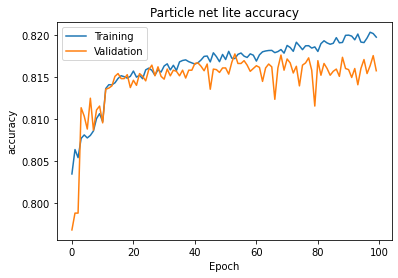

In [41]:
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Particle net lite accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

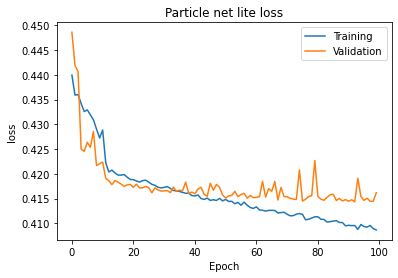

In [42]:
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Particle net lite loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [43]:
res = model.evaluate(test_dataset, y_test)

469/469 [==============================] - 9s 20ms/step - loss: 0.5166 - accuracy: 0.7531


In [44]:
print("test loss, test acc:", res)

test loss, test acc: [0.5165840983390808, 0.7530666589736938]


Conclusion

We built a classical GNN using Tensorflow. Considering the plots for particle net lite, the training loss decreases over epochs and also the training accuracy increases which means the model fits the data. However, the validation loss and accuracy beocmes constant after near 20th epoch which shows the overfitting. The training accuracy is near 82% which is comparable to the results of the paper [Jet tagging via particle clouds](https://journals.aps.org/prd/pdf/10.1103/PhysRevD.101.056019). Theirs is 82.6%. One thing to note that the model takes significant amount of time for training for 10000 samples of data.